In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import os
from tqdm import tqdm_notebook as tqdm
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas
import re
import os
import pickle

In [2]:
def get_lemma_distribution(file_name):
    lemmas=[]
    pattern = re.compile('http://en.wikipedia.org/wiki/[a-z,A-z,_]+$')
    for line in open(file_name):
        url=line.strip().split(' ')[2]
        if not pattern.match(url):
            continue
        lemma=url[url.rfind('/')+1:]
        if '.' in lemma:
            continue
        lemmas.append(lemma)
    return lemmas

In [6]:
visit_count=dict()
for filename in tqdm(os.listdir('./data/only_lemma/')):
    lemmas=get_lemma_distribution('./data/only_lemma/%s'%filename)
    for entry in lemmas:
        try:
            visit_count[entry]+=1
        except:
            visit_count[entry]=1

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/xuanli2/penv/lib/python3.5/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/xuanli2/penv/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



KeyboardInterrupt: 

In [9]:
visit_count_df=pandas.DataFrame(list(visit_count.items()),columns=['Entry','Visit Count'])

In [10]:
visit_count_df=visit_count_df.to_csv('./data/entry_visit_count.csv',index=False)

In [7]:
visit_count_df=pandas.read_csv('./data/entry_visit_count.csv')

In [5]:
visit_count_df=pickle.load(open('./data/dump/hot_words_100000.pkl','rb'))

In [9]:
visit_count_df

Main_Page                             13601719
Wiki                                    444697
Halo_3                                  217926
Wikipedia                               148431
Naruto                                  120657
United_States                           107160
Deaths_in_2007                          102920
Sex                                      97584
Heroes_%28TV_series%29                   94180
HTTP                                     88070
Love                                     87235
MySpace                                  87024
YouTube                                  81909
sort_none.gif                            77914
sort_down.gif                            77278
sort_up.gif                              77181
Politics                                 75759
Cocaine                                  73282
Myanmar                                  71498
Google                                   70221
Jena_Six                                 70125
Laser        

In [22]:
visit_count_df=visit_count_df.to_frame()

In [29]:
visit_count_df.head()

,b
Main_Page,13601719
Wiki,444697
Halo_3,217926
Wikipedia,148431
Naruto,120657


In [30]:
visit_count_df.columns=['Visit Count']

In [31]:
visit_count_df=visit_count_df.dropna(axis=0, how='any')

In [32]:
from pymongo import MongoClient
import pandas
from tqdm import tqdm_notebook as tqdm
import re
client = MongoClient()
db = client.get_database('wikipedia')

In [12]:
data=[]
for page in tqdm(db.page_text.find()):
    data.append([page['title'],page['length']])
page_len=pandas.DataFrame(data,columns=['page_title','page_len'])

In [45]:
visit_count_df.head()

,Visit Count,Entry
Main_Page,13601719,Main_Page
Wiki,444697,Wiki
Halo_3,217926,Halo_3
Wikipedia,148431,Wikipedia
Naruto,120657,Naruto


In [44]:
visit_count_df['Entry'] = visit_count_df.index

In [46]:
page_len.head()

,page_title,page_len
28,South_park,89
44,Britney_spears,93
45,Family_guy,56
46,Burj_Dubai,97
47,Darfur_conflict,27


/home/xuanli2/penv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


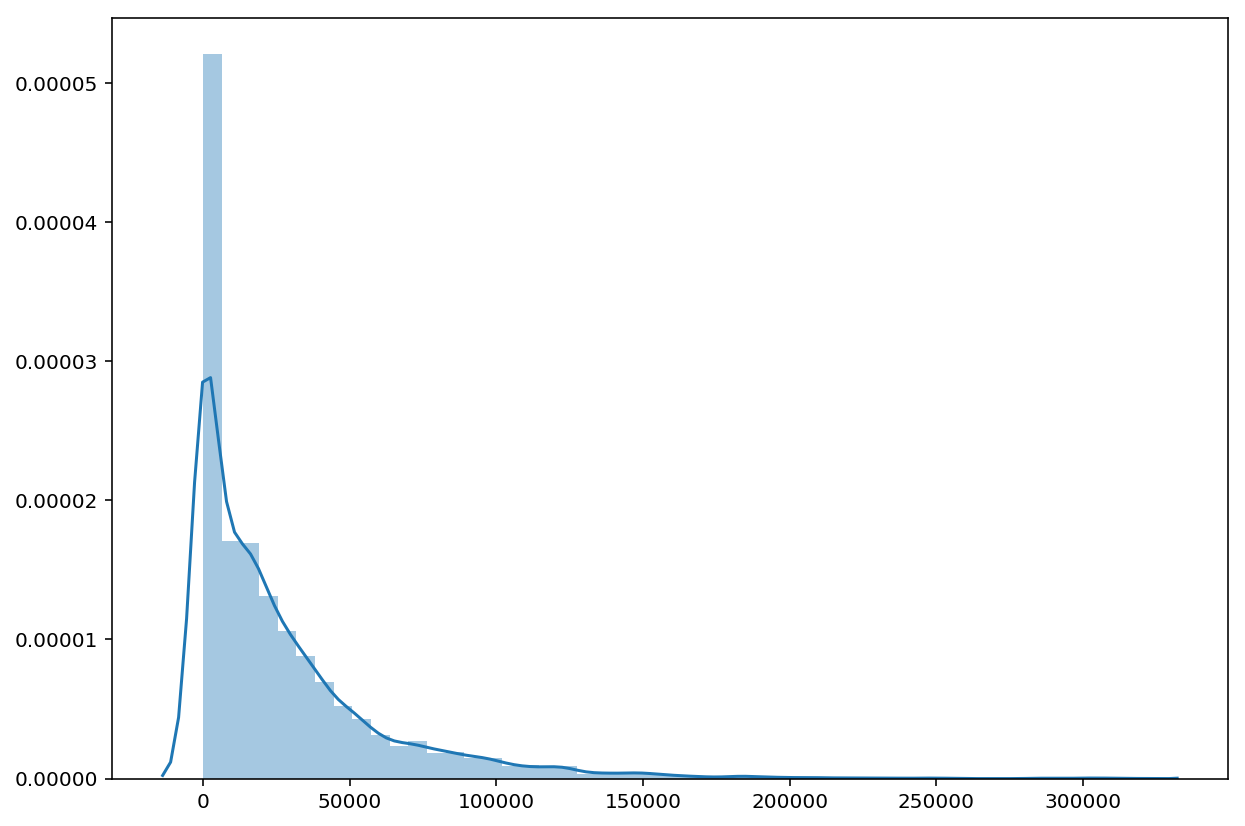

In [47]:
plt.figure(figsize=(10,7))
sns.distplot(np.random.choice(page_len['page_len'].values,10000))
plt.show()

In [48]:
title_counts=page_len['page_title'].value_counts()

In [49]:
page_len=page_len[page_len['page_title'].isin(title_counts[title_counts<2].index)]

In [50]:
len(page_len)

76442

In [51]:
merged_df=pandas.merge(page_len, visit_count_df, left_on="page_title",right_on="Entry")

In [52]:
len(merged_df)

72712

In [53]:
filtered_df=merged_df.sort_values('Visit Count',ascending=False)[:100000]

In [55]:
len(filtered_df)

72712

In [287]:
filtered_df=filtered_df[filtered_df['page_len']<filtered_df["page_len"].quantile(0.99)]

In [300]:
filtered_df=filtered_df[filtered_df['Visit Count']<filtered_df["Visit Count"].quantile(0.999)]

In [301]:
filtered_df=filtered_df[filtered_df['Visit Count']>filtered_df["Visit Count"].quantile(0.001)]

In [321]:
filtered_df['page_len'].max()

120526

In [322]:
filtered_df['page_len'].min()

15

In [323]:
filtered_df['Visit Count'].max()

37260

In [324]:
filtered_df['Visit Count'].min()

45

In [305]:
filtered_df['page_len_bin'] = pandas.cut(filtered_df['page_len'], range(0,filtered_df['page_len'].max(),500))
filtered_df['visit_count_bin'] = pandas.cut(filtered_df['Visit Count'], range(0,filtered_df['Visit Count'].max(),500))

In [306]:
filtered_df.head()

,page_title,page_counter,page_len,Entry,Visit Count,page_len_bin,visit_count_bin
744285,Miley_cyrus,0,57,Miley_cyrus,3698,"(0, 500]",NaN
26424,Sociopath,0,24,Sociopath,3679,"(0, 500]",NaN
370325,Computer_mouse,0,31,Computer_mouse,3674,"(0, 500]",NaN
154193,Human_Resources_Management,0,39,Human_Resources_Management,3669,"(0, 500]",NaN
1012007,Eva_Pigford,0,26,Eva_Pigford,3612,"(0, 500]",NaN


In [325]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [57]:
filtered_df.to_csv('./data/dump/visit_count_vs_page_length.csv',index=False)

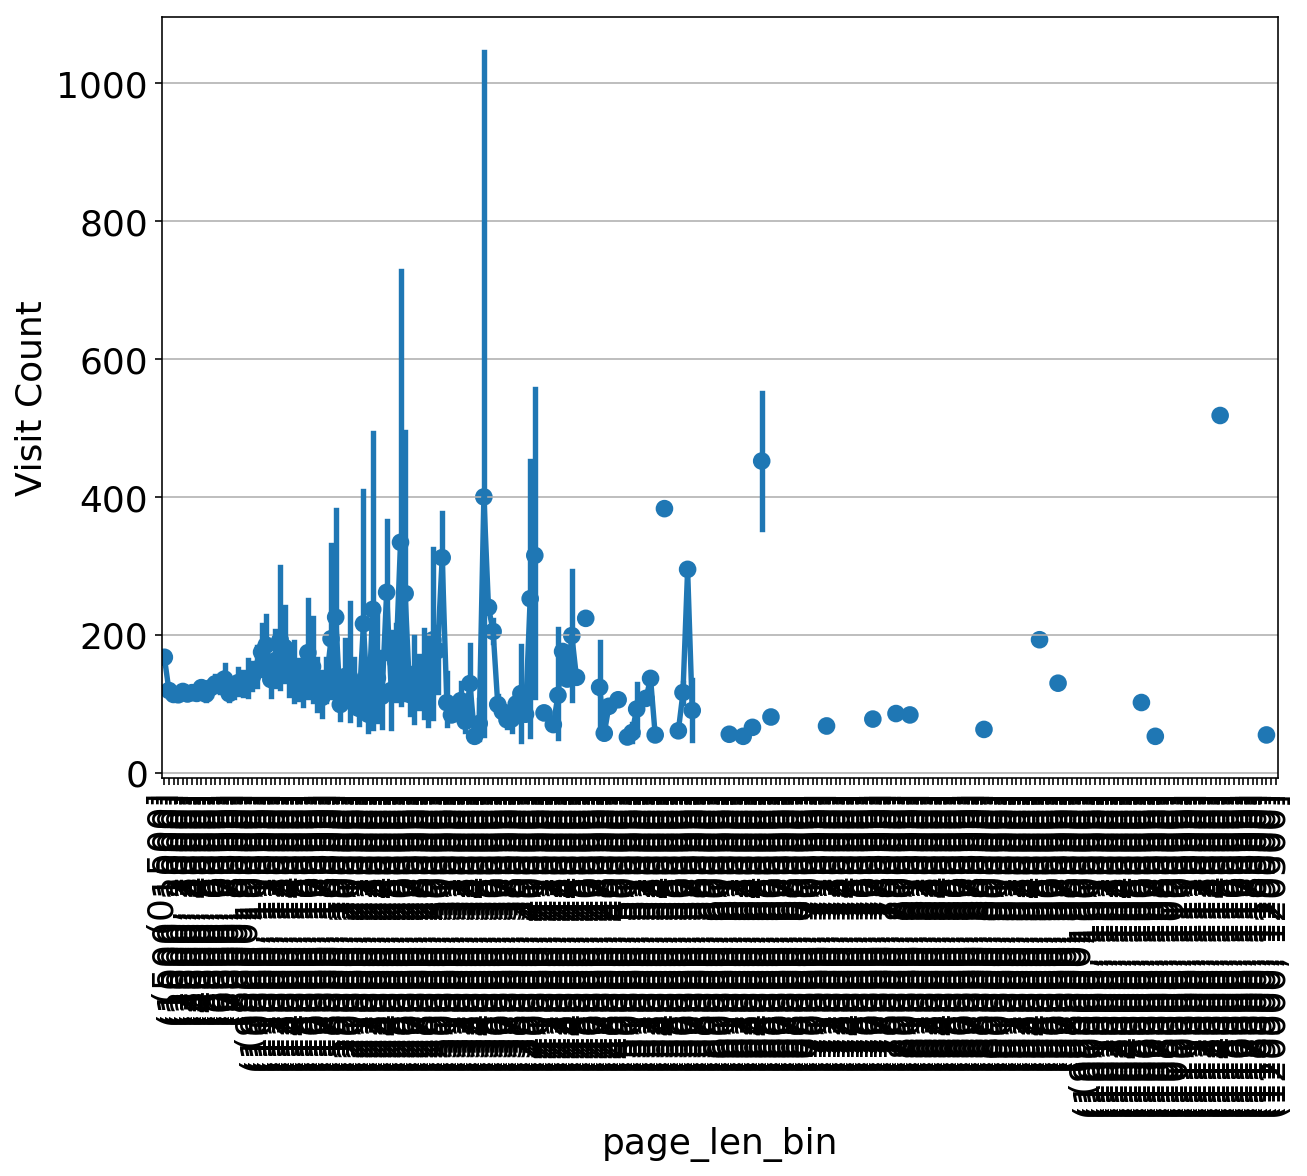

In [309]:
plt.figure(figsize=(10,7))
sns.pointplot(x="page_len_bin", y="Visit Count", data=filtered_df)
plt.xticks(rotation='vertical')
# plt.xlabel('Page Length')
plt.grid(axis='y')
# plt.ylim((10,None))
plt.savefig('./plots/visit_count_vs_page_length.pdf')
plt.show()

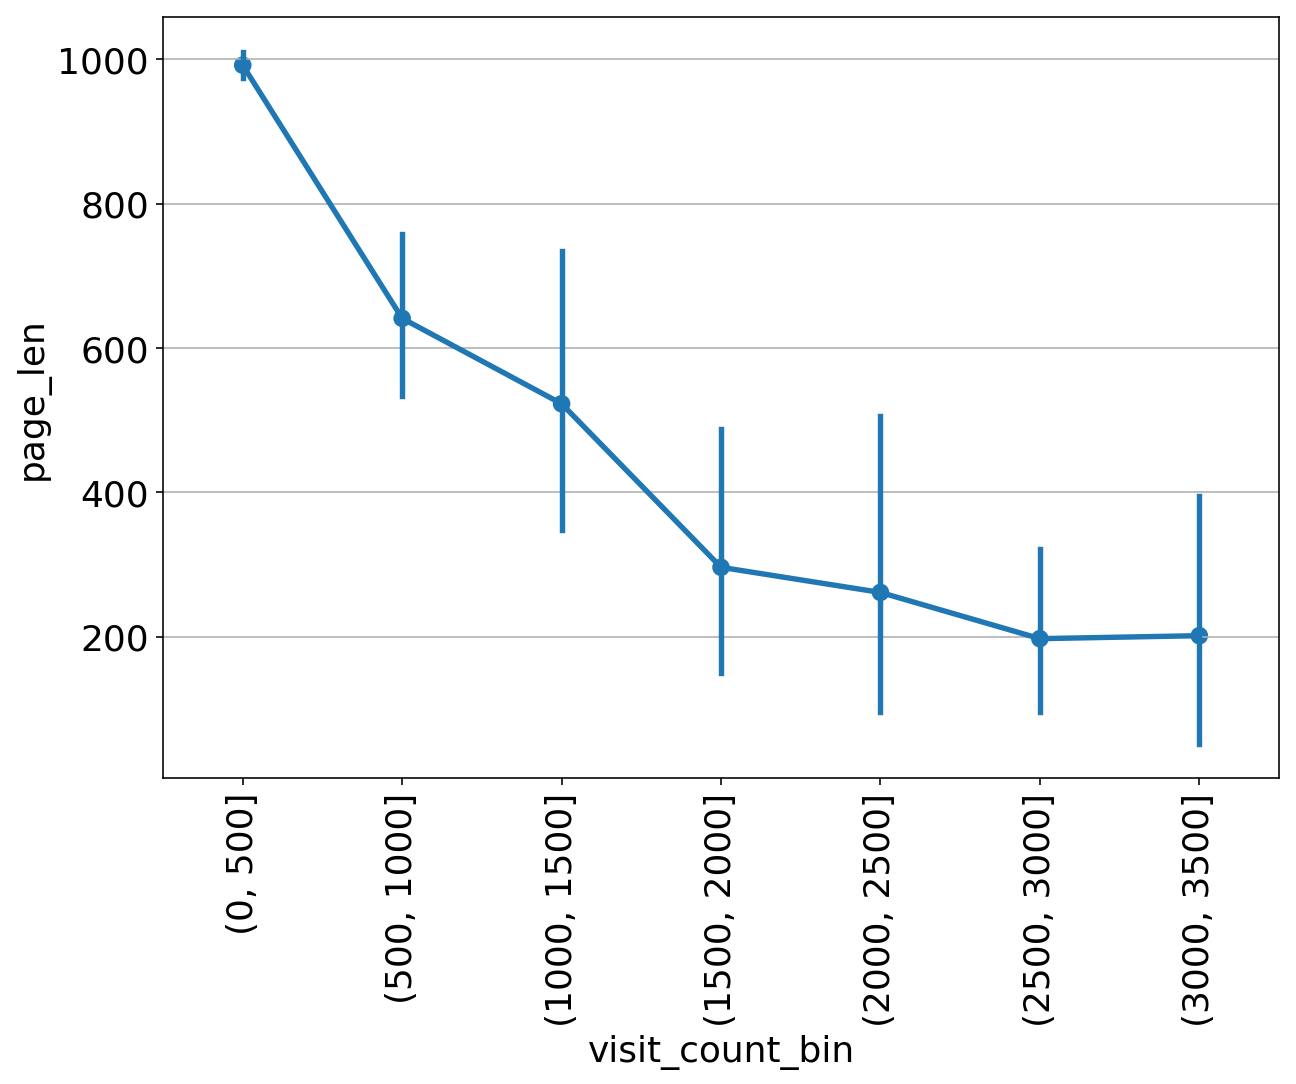

In [310]:
plt.figure(figsize=(10,7))
sns.pointplot(x="visit_count_bin", y="page_len", data=filtered_df)
plt.xticks(rotation='vertical')
# plt.xlabel('Page Length')
plt.grid(axis='y')
# plt.ylim((10,None))
plt.savefig('./plots/visit_count_vs_page_length.pdf')
plt.show()